In [1]:
!pip install pennylane
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

print("libraries are imported successfully")

libraries are imported successfully


In [3]:
def set_seed(seed=42):
    # NumPy
    np.random.seed(seed)

    # Python Random
    random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic algorithms
    torch.use_deterministic_algorithms(True)




In [4]:
def apply_pca(features, n_components=256):
    pca = PCA(n_components=n_components)
    return torch.tensor(pca.fit_transform(features.numpy()), dtype=torch.float)

In [32]:
def cora_data_node_selection(batch_size=32, num_nodes=1024):
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    data = dataset[0]


    num_nodes = 1024
    selected_nodes = torch.randperm(data.x.shape[0])[:num_nodes]
    x = apply_pca(data.x[selected_nodes])
    y = data.y[selected_nodes]


    class_0, class_1 = 2, 4
    mask = (y == class_0) | (y == class_1)
    x = x[mask]
    y_binary = (y[mask] == class_1).long()

    train_ratio = 0.8
    train_size = int(train_ratio * x.shape[0])
    test_size = x.shape[0] - train_size
    train_x, test_x = x[:train_size], x[train_size:]
    train_y, test_y = y_binary[:train_size], y_binary[train_size:]

    train_dataset = TensorDataset(train_x, train_y)
    test_dataset = TensorDataset(test_x, test_y)
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    A = to_dense_adj(data.edge_index).squeeze(0)
    A = A[selected_nodes][:, selected_nodes]
    A = A[mask][:, mask]
    A = A + torch.eye(A.shape[0])
    D_inv_sqrt = torch.diag(1.0 / torch.sqrt(A.sum(dim=1)))
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt
    return train_loader, test_loader, A_norm, len(test_dataset)

In [33]:
train_data, test_data, A_norm, len_test = cora_data_node_selection(num_nodes=1024)

In [34]:
def Rot_layer(gate, w):
    """
    Applies a given rotation gate (e.g., qml.RY or qml.RZ) to each qubit
    with the corresponding parameter in w.
    """
    for idx, element in enumerate(w):
        gate(element, wires=idx)

def entangling_layer(nqubits):
    """
    Applies a ring of CNOT gates to entangle all qubits.
    """
    for i in range(nqubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[nqubits - 1, 0])


In [35]:
def quantum_net(n_qubits, q_depth, feature_dim):
    """
    Variational quantum circuit used in the graph convolution layer.
    Uses amplitude encoding to embed a feature vector of length 'feature_dim'
    (which should equal 2^n_qubits) into the quantum state.
    Then applies q_depth layers of parameterized rotations and entangling gates.
    """

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface='torch')
    def quantum_circuit(inputs, q_weights_flat):

        eps = 1e-7
        inputs = inputs + eps
        qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)


        q_weights = q_weights_flat.reshape(q_depth, 2, n_qubits)


        for k in range(q_depth):
            Rot_layer(qml.RY, q_weights[k][0])
            entangling_layer(n_qubits)
            Rot_layer(qml.RZ, q_weights[k][1])


        exp_vals = [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        return exp_vals


    num_params = 2 * q_depth * n_qubits

    return qml.qnn.TorchLayer(quantum_circuit, {"q_weights_flat": (num_params,)}), quantum_circuit


In [36]:
def givens_rotation_matrix(theta, i, j, size):
    G = torch.eye(size)
    # Convert theta to a PyTorch tensor
    theta = torch.tensor(theta, dtype=torch.float32)
    c, s = torch.cos(theta/2), torch.sin(theta/2)
    G[i, i], G[i, j] = c, s
    G[j, i], G[j, j] = -s, c
    return G

def quantum_message_passing(features, A_norm):
    batch_size = features.shape[0]  # Get the batch size
    updated_features = features.clone()

    # Iterate over nodes in the batch
    for i in range(batch_size):
        for j in range(batch_size):  # Iterate over all nodes in the graph
            if A_norm[i, j] > 0:  # Check for connection between nodes i and j
                theta = np.pi/2

                # Apply rotation to the features of nodes i and j within the batch
                # Create a 2x2 Givens rotation matrix for the 2 nodes
                G = givens_rotation_matrix(theta, 0, 1, 2)

                # Extract features for nodes i and j
                # Select only the first two features for the rotation
                node_features = torch.stack([updated_features[i][:2], updated_features[j][:2]])

                # Apply rotation and update features
                rotated_features = torch.mv(G, node_features[0])
                # Update only the first two features for node i
                updated_features[i][:2] = rotated_features
    return updated_features

In [37]:
class QuantumGCN(torch.nn.Module):
    def __init__(self, n_qubits, n_classes=2):
        super().__init__()
        self.q_feature = quantum_net(n_qubits, 7, 256)[0]
        self.fc = torch.nn.Linear(n_qubits, n_classes)

    def forward(self, x, A_norm):
        x = self.q_feature(x)
        x = quantum_message_passing(x, A_norm)
        return self.fc(x)

In [38]:
device = torch.device("cpu")
model = QuantumGCN(8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
A_norm = A_norm.to(device)

In [40]:
set_seed(53)
train_losses = []
test_accuracies = []
for epoch in range(100):
    model.train()
    total_loss = 0

    for batch_x, batch_y in tqdm(train_data):

        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_x, A_norm)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_data))


    model.eval()
    correct = 0
    with torch.no_grad():

        for batch_x, batch_y in test_data:

            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            out = model(batch_x, A_norm)
            pred = out.argmax(dim=1)
            correct += (pred == batch_y).sum().item()
    accuracy = correct / len_test
    test_accuracies.append(accuracy)

    if epoch % 1 == 0:
        print(f"\nEpoch {epoch}: Loss = {train_losses[-1]:.4f}, Accuracy = {accuracy:.4f}")

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]



Epoch 0: Loss = 0.4852, Accuracy = 0.5238


100%|██████████| 8/8 [00:02<00:00,  3.15it/s]



Epoch 1: Loss = 0.4733, Accuracy = 0.5397


100%|██████████| 8/8 [00:01<00:00,  4.18it/s]



Epoch 2: Loss = 0.4595, Accuracy = 0.5397


100%|██████████| 8/8 [00:01<00:00,  4.09it/s]



Epoch 3: Loss = 0.4503, Accuracy = 0.5397


100%|██████████| 8/8 [00:01<00:00,  4.19it/s]



Epoch 4: Loss = 0.4346, Accuracy = 0.5556


100%|██████████| 8/8 [00:01<00:00,  4.21it/s]



Epoch 5: Loss = 0.4263, Accuracy = 0.5873


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]



Epoch 6: Loss = 0.4180, Accuracy = 0.5873


100%|██████████| 8/8 [00:02<00:00,  3.99it/s]



Epoch 7: Loss = 0.4045, Accuracy = 0.5873


100%|██████████| 8/8 [00:02<00:00,  3.95it/s]



Epoch 8: Loss = 0.3977, Accuracy = 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.10it/s]



Epoch 9: Loss = 0.3890, Accuracy = 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.13it/s]



Epoch 10: Loss = 0.3790, Accuracy = 0.5556


100%|██████████| 8/8 [00:02<00:00,  3.82it/s]



Epoch 11: Loss = 0.3734, Accuracy = 0.5714


100%|██████████| 8/8 [00:02<00:00,  3.23it/s]



Epoch 12: Loss = 0.3654, Accuracy = 0.5714


100%|██████████| 8/8 [00:01<00:00,  4.15it/s]



Epoch 13: Loss = 0.3597, Accuracy = 0.5873


100%|██████████| 8/8 [00:01<00:00,  4.10it/s]



Epoch 14: Loss = 0.3517, Accuracy = 0.6032


100%|██████████| 8/8 [00:02<00:00,  3.27it/s]



Epoch 15: Loss = 0.3436, Accuracy = 0.6190


100%|██████████| 8/8 [00:01<00:00,  4.25it/s]



Epoch 16: Loss = 0.3341, Accuracy = 0.6190


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]



Epoch 17: Loss = 0.3331, Accuracy = 0.6349


100%|██████████| 8/8 [00:01<00:00,  4.09it/s]



Epoch 18: Loss = 0.3210, Accuracy = 0.6667


100%|██████████| 8/8 [00:01<00:00,  4.23it/s]



Epoch 19: Loss = 0.3156, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.17it/s]



Epoch 20: Loss = 0.3092, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.10it/s]



Epoch 21: Loss = 0.3033, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  3.46it/s]



Epoch 22: Loss = 0.2991, Accuracy = 0.6984


100%|██████████| 8/8 [00:02<00:00,  3.87it/s]



Epoch 23: Loss = 0.2878, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.19it/s]



Epoch 24: Loss = 0.2833, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.19it/s]



Epoch 25: Loss = 0.2773, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.18it/s]



Epoch 26: Loss = 0.2748, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.15it/s]



Epoch 27: Loss = 0.2681, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]



Epoch 28: Loss = 0.2613, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.21it/s]



Epoch 29: Loss = 0.2609, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.07it/s]



Epoch 30: Loss = 0.2548, Accuracy = 0.6667


100%|██████████| 8/8 [00:02<00:00,  3.98it/s]



Epoch 31: Loss = 0.2511, Accuracy = 0.6667


100%|██████████| 8/8 [00:01<00:00,  4.12it/s]



Epoch 32: Loss = 0.2444, Accuracy = 0.6667


100%|██████████| 8/8 [00:02<00:00,  3.36it/s]



Epoch 33: Loss = 0.2347, Accuracy = 0.6667


100%|██████████| 8/8 [00:02<00:00,  3.51it/s]



Epoch 34: Loss = 0.2333, Accuracy = 0.6667


100%|██████████| 8/8 [00:02<00:00,  3.25it/s]



Epoch 35: Loss = 0.2328, Accuracy = 0.6667


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]



Epoch 36: Loss = 0.2237, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.29it/s]



Epoch 37: Loss = 0.2211, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  3.16it/s]



Epoch 38: Loss = 0.2201, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  3.84it/s]



Epoch 39: Loss = 0.2175, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.34it/s]



Epoch 40: Loss = 0.2136, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.23it/s]



Epoch 41: Loss = 0.2096, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.03it/s]



Epoch 42: Loss = 0.2087, Accuracy = 0.6984


100%|██████████| 8/8 [00:02<00:00,  3.73it/s]



Epoch 43: Loss = 0.2071, Accuracy = 0.6667


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]



Epoch 44: Loss = 0.2009, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  3.87it/s]



Epoch 45: Loss = 0.1992, Accuracy = 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.34it/s]



Epoch 46: Loss = 0.1977, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.37it/s]



Epoch 47: Loss = 0.1930, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.14it/s]



Epoch 48: Loss = 0.1913, Accuracy = 0.6984


100%|██████████| 8/8 [00:02<00:00,  3.20it/s]



Epoch 49: Loss = 0.1876, Accuracy = 0.6984


100%|██████████| 8/8 [00:02<00:00,  3.81it/s]



Epoch 50: Loss = 0.1841, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.16it/s]



Epoch 51: Loss = 0.1848, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.18it/s]



Epoch 52: Loss = 0.1830, Accuracy = 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.18it/s]



Epoch 53: Loss = 0.1761, Accuracy = 0.7143


100%|██████████| 8/8 [00:01<00:00,  4.26it/s]



Epoch 54: Loss = 0.1759, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]



Epoch 55: Loss = 0.1718, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.52it/s]



Epoch 56: Loss = 0.1702, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.11it/s]



Epoch 57: Loss = 0.1679, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.48it/s]



Epoch 58: Loss = 0.1652, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.13it/s]



Epoch 59: Loss = 0.1654, Accuracy = 0.6984


100%|██████████| 8/8 [00:02<00:00,  3.41it/s]



Epoch 60: Loss = 0.1605, Accuracy = 0.6984


100%|██████████| 8/8 [00:02<00:00,  3.31it/s]



Epoch 61: Loss = 0.1610, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.10it/s]



Epoch 62: Loss = 0.1572, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.13it/s]



Epoch 63: Loss = 0.1580, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  3.27it/s]



Epoch 64: Loss = 0.1501, Accuracy = 0.6825


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]



Epoch 65: Loss = 0.1513, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]



Epoch 66: Loss = 0.1518, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.16it/s]



Epoch 67: Loss = 0.1442, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.09it/s]



Epoch 68: Loss = 0.1452, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.04it/s]



Epoch 69: Loss = 0.1445, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.51it/s]



Epoch 70: Loss = 0.1441, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]



Epoch 71: Loss = 0.1387, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  3.93it/s]



Epoch 72: Loss = 0.1367, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.22it/s]



Epoch 73: Loss = 0.1358, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.08it/s]



Epoch 74: Loss = 0.1342, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.39it/s]



Epoch 75: Loss = 0.1329, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.20it/s]



Epoch 76: Loss = 0.1308, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  3.27it/s]



Epoch 77: Loss = 0.1305, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.25it/s]



Epoch 78: Loss = 0.1297, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.24it/s]



Epoch 79: Loss = 0.1288, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.13it/s]



Epoch 80: Loss = 0.1273, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.20it/s]



Epoch 81: Loss = 0.1232, Accuracy = 0.6984


100%|██████████| 8/8 [00:02<00:00,  3.19it/s]



Epoch 82: Loss = 0.1225, Accuracy = 0.6984


100%|██████████| 8/8 [00:02<00:00,  3.68it/s]



Epoch 83: Loss = 0.1202, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.30it/s]



Epoch 84: Loss = 0.1196, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.33it/s]



Epoch 85: Loss = 0.1199, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.10it/s]



Epoch 86: Loss = 0.1191, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.32it/s]



Epoch 87: Loss = 0.1175, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]



Epoch 88: Loss = 0.1160, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.39it/s]



Epoch 89: Loss = 0.1127, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.31it/s]



Epoch 90: Loss = 0.1132, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.30it/s]



Epoch 91: Loss = 0.1119, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.44it/s]



Epoch 92: Loss = 0.1088, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.07it/s]



Epoch 93: Loss = 0.1092, Accuracy = 0.6825


100%|██████████| 8/8 [00:02<00:00,  3.20it/s]



Epoch 94: Loss = 0.1073, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.16it/s]



Epoch 95: Loss = 0.1091, Accuracy = 0.6825


100%|██████████| 8/8 [00:01<00:00,  4.06it/s]



Epoch 96: Loss = 0.1065, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.19it/s]



Epoch 97: Loss = 0.1064, Accuracy = 0.6984


100%|██████████| 8/8 [00:01<00:00,  4.04it/s]



Epoch 98: Loss = 0.1039, Accuracy = 0.6984


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]



Epoch 99: Loss = 0.1012, Accuracy = 0.6984


In [41]:
def plot_loss_accuracy(train_losses, test_accuracies):
    plt.figure(figsize=(12, 4))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

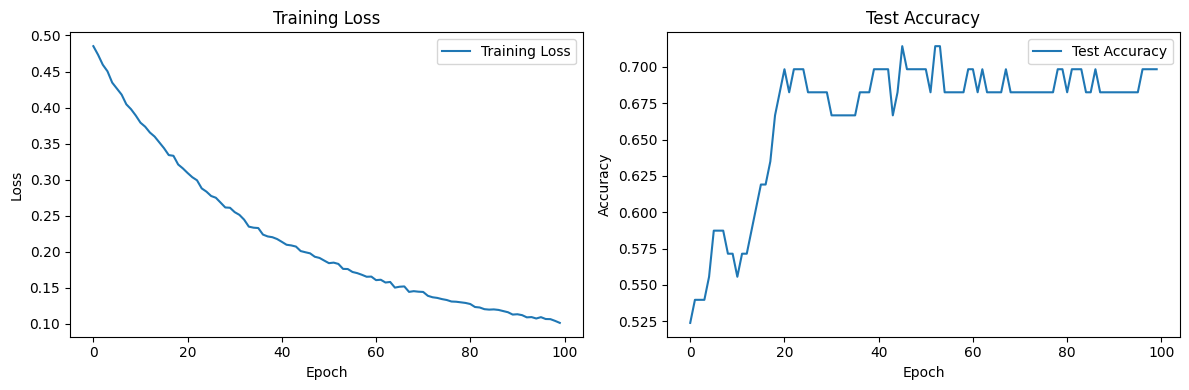

In [42]:
plot_loss_accuracy(train_losses, test_accuracies)